In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
#pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
!pip install git+https://github.com/quantopian/pyfolio
import pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-_gmzuzul
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-_gmzuzul
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp36-none-any.whl size=75766 sha256=285f11ade737a2388ff521d02a1c20727680c78d17ec4472e1131f48458cc60e
  Stored in directory: /tmp/pip-ephem-wheel-cache-010l86gn/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
Successfully built pyfolio


In [ ]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [ ]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [ ]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [ ]:
!cp -a "drive/My Drive/Backtest_final/model/" .
!cp -a "drive/My Drive/Backtest_final/preprocessing/" .
!cp -a "drive/My Drive/Backtest_final/config/" .
!cp -a "drive/My Drive/Backtest_final/env/" .
!cp -a "drive/My Drive/Backtest_final/data/" .
!cp -a "drive/My Drive/Backtest_final/results/" .

In [42]:
def get_account_value1(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        sum_temp = pd.read_csv('results/account_value_trade_{}_{}_9.csv'.format(model_name,i))
        for j in range(9):
            temp = pd.read_csv('results/account_value_trade_{}_{}_{}.csv'.format(model_name,i,j))
            sum_temp = temp + sum_temp
        df_account_value = df_account_value.append(sum_temp / 10,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

In [43]:
dji = pd.read_csv("data/^DJI.csv")
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
test_dji = test_dji.reset_index(drop=True)

In [44]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [45]:
dow_strat = backtest_strat(test_dji)

In [46]:
df=pd.read_csv('data/dow_30_2009_2020.csv')

In [47]:
rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()


In [48]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [49]:
ensemble_account_value = get_account_value1('ensemble')

1.0148193643234709


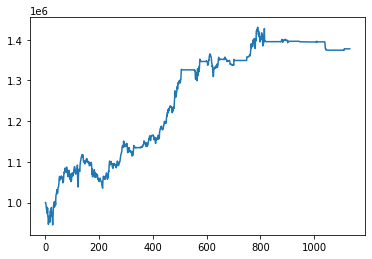

In [50]:
ensemble_account_value.account_value.plot()

In [51]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  1.0148193643234709


In [52]:
ensemble_account_value['Date'] = test_dji['Date']

In [53]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1000000.000000,20160104,NaN,2016-01-04
1,999578.864984,20160105,-0.000421,2016-01-05
2,995734.229352,20160106,-0.003846,2016-01-06
3,988307.799330,20160107,-0.007458,2016-01-07
4,983575.468024,20160108,-0.004788,2016-01-08


In [54]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [ ]:
#ensemble_account_value.to_csv('results/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2016-01-04
End date,2020-05-12
Total months,52
,Backtest
Annual return,7.577%
Cumulative returns,37.432%
Annual volatility,7.405%
Sharpe ratio,1.02
Calmar ratio,1.02
Stability,0.88
Max drawdown,-7.394%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.39,2016-07-20,2016-11-04,2017-02-15,151
1,5.49,2016-01-04,2016-02-11,2016-02-22,36
2,4.93,2016-06-23,2016-06-27,2016-07-08,12
3,4.10,2018-06-08,2018-06-27,2019-01-15,158
4,3.94,2019-02-25,2020-04-08,NaT,NaN


/usr/local/lib/python3.6/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


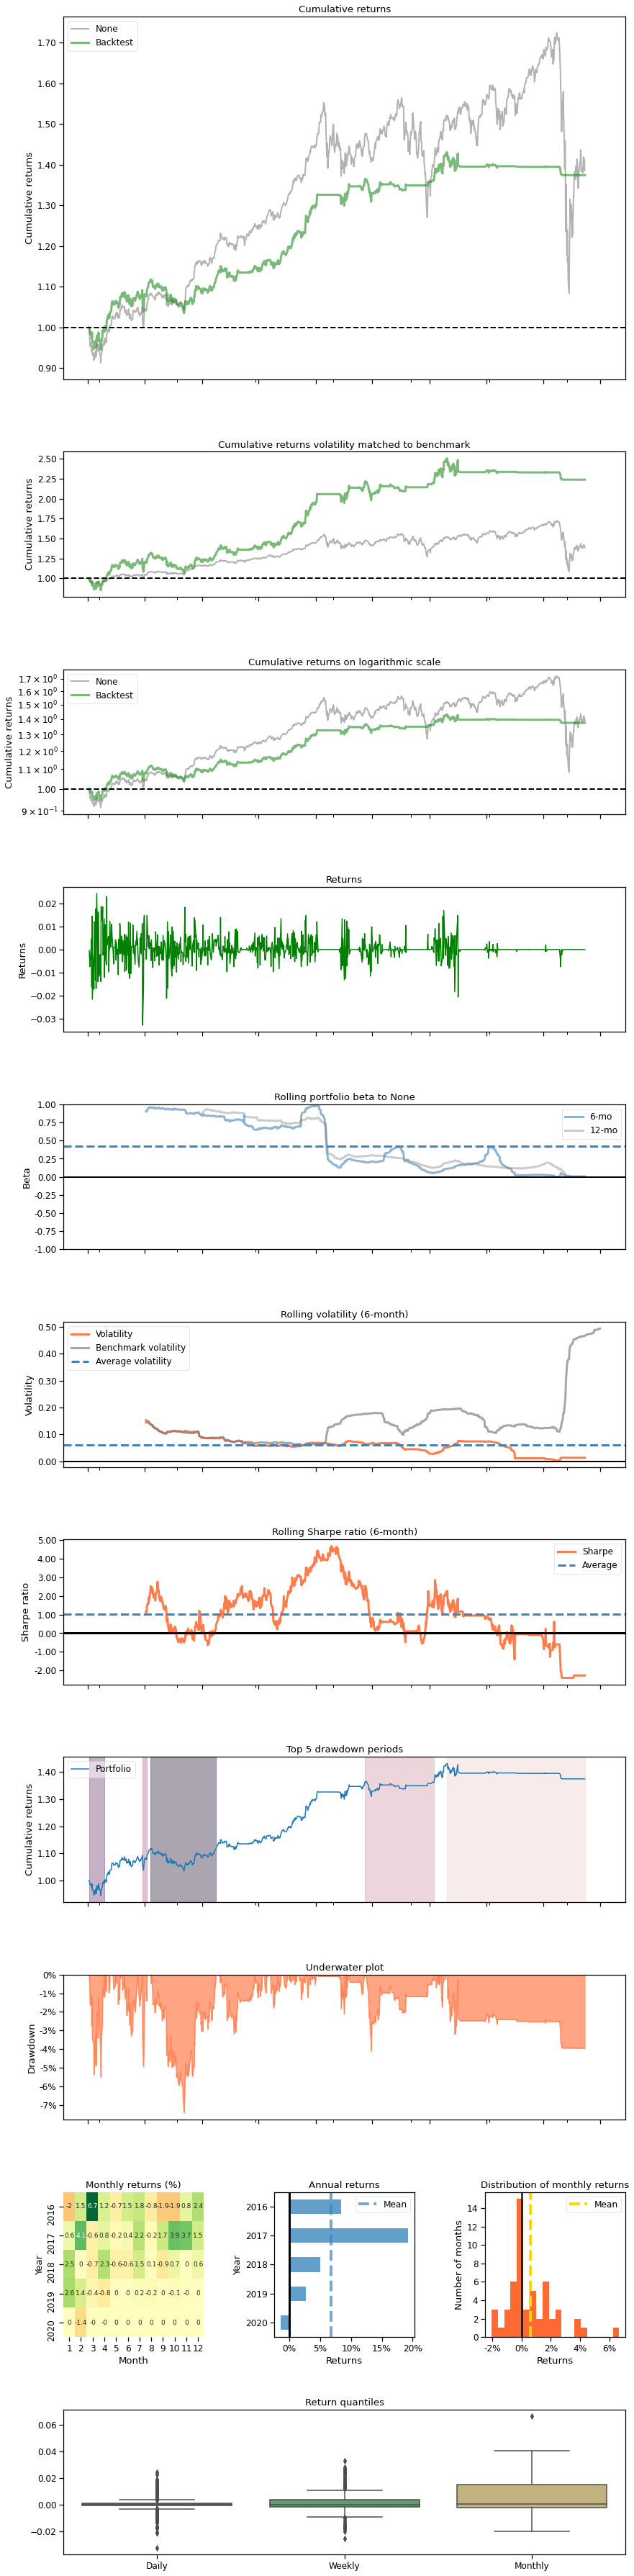

In [55]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)